In [1]:
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from estimagic.differentiation.derivatives import first_derivative

sns.set_style("whitegrid")

### Code to integrate

In [2]:
def _convert_jac_candidates_to_frame(jac_candidates):
    """Convert jacobian candidates to data frame.

    Assumes ``n_steps`` > 1.

    Args:
        jac_candidates (dict): Dict with jac candidates.

    Returns:
        df (pd.DataFrame): Frame with column "value" and index
            ["method", "kind", "dim_x", "dim_f"]
            with respective meaning: type of method used, e.g. central or foward;
            kind of value, e.g. derivative or error.

    """
    num_terms, dim_f, dim_x = jac_candidates["forward1"]["derivative"].shape
    x_index = range(dim_x)
    f_index = range(dim_f)

    dfs = []
    subset = [key for key in jac_candidates.keys() if str(num_terms) in key]
    for method in subset:
        for key, value in jac_candidates[method].items():
            data = value.transpose((0, 2, 1)).reshape(-1, dim_f)
            df = pd.DataFrame(data, columns=f_index)
            df = df.assign(**{"dim_x": x_index})
            df = df.melt(id_vars="dim_x", var_name="dim_f")
            df = df.assign(**{"method": method[:-1], "kind": key})
            dfs.append(df)

    df = pd.concat(dfs)
    df = df.set_index(["method", "kind", "dim_x", "dim_f"])
    return df

In [3]:
def visualize_derivative(df_evals, df_deriv, func_value, dim_x=None, dim_f=None, height=5, width=5):
    """Plot evaluations and derivative estimates.
    
    Args:
        df_evals (pd.DataFrame): Frame containing func evaluations (long-format).
        df_deriv (pd.DataFrame): Frame containing derivative estimates (long-format).
        func_value (np.ndarray): Func value at original params vector.
        dim_x (iterable): Input dimension to consider. Default None, which selects all.
        dim_f (iterable): Output dimensions to consider. Default None, which selects all.
        height (float): Height of represenative plot in grid.
        width (float): Width of representative plot in grid.
        
    Returns:
        grid (sns.FacetGrid): Plot.
        
    """
    def _get_der(df, method, dim_x, dim_f):
        """Quick access to derivative and error entry."""
        df = df.query("method == @method & dim_x == @dim_x & dim_f == @dim_f")
        values = df.reset_index(level=["method", "dim_x", "dim_f"], drop=True)["value"]
        return values
    
    palette = {
        "forward": "tab:green",
        "central": "tab:blue",
        "backward": "tab:orange"
    }

    df = df_evals.copy().reset_index()
    df = df.assign(**{"step": df.step * df.sign})
    
    dimensions = df[["dim_x", "dim_f"]].max()
    dim_x = dim_x if dim_x is not None else range(dimensions["dim_x"] + 1)
    dim_f = dim_f if dim_f is not None else range(dimensions["dim_f"] + 1)
    df = df.query("dim_x in @dim_x & dim_f in @dim_f")

    max_steps = df.groupby("dim_x")["step"].max()

    grid = sns.FacetGrid(df, row="dim_x", col="dim_f", sharey=False, height=height, aspect=width/height)
    grid.map(sns.scatterplot, "step", "eval", color="black", label="Func eval")
    grid.set_titles(template="dim_x, dim_f = {row_name}, {col_name}")
    grid.set_axis_labels("Param Value", "Func Value")

    for row, col in itertools.product(dim_x, dim_f):
        ax = grid.axes[row, col]
        _x = np.linspace(-max_steps[row], max_steps[row], 100)
        for method in ["forward", "central", "backward"]:
            der = _get_der(df_deriv, method, row, col)
            _y = _x * der["derivative"] + func_value[col]
            ax.plot(_x, _y, color=palette[method], alpha=1 - der["error"], label=method)
        ax.legend()
            
    return grid

### Example

In [4]:
def func(x):
    y1 = x[0] ** 2 + x[1] ** 3 + x[0] * x[1]
    y2 = 1 + x[0]
    return np.array([y1, y2])

params = np.zeros(3)

In [5]:
n_steps, dim_x, dim_f = 5, len(params), len(func(params))

der, info, candidates = first_derivative(
    func, params, n_steps=n_steps, return_func_value=True, return_evals=True
)

func_value = info["func_value"]
df_evals = info["df_evals"]

In [6]:
df_deriv = _convert_jac_candidates_to_frame(candidates)

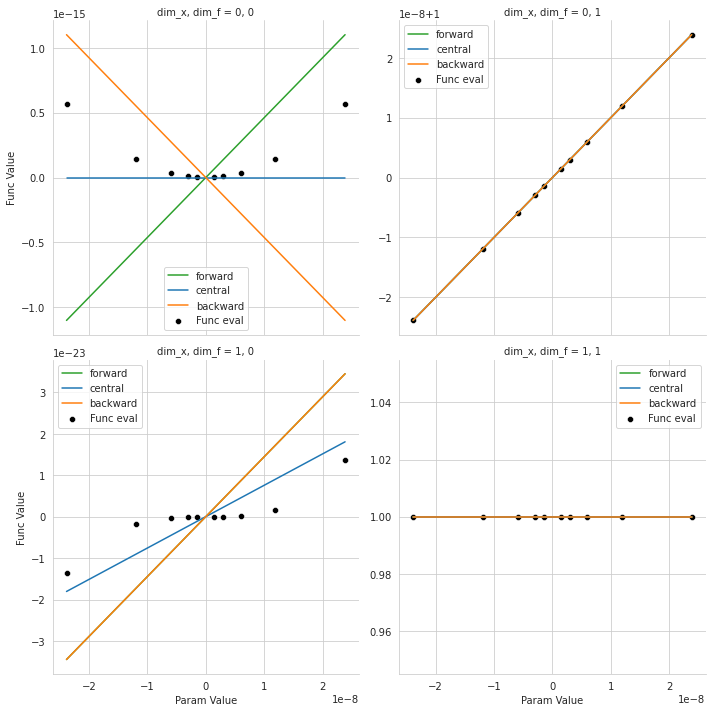

In [7]:
visualize_derivative(df_evals, df_deriv, func_value, dim_x=[0, 1])